In [1]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_vacf, compute_rotational_msd
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

In [2]:
hp_root = '/home/mmccraw/dev/data/09-27-25/dt-study/'
nv_hist = []
mu_hist = []
p_hist = []
temp_hist = []
phi_hist = []
msd_hist = []
t_hist = []
te_fluc_hist = []
rel_te_fluc_hist = []
dt_hist = []
for dt_root in os.listdir(hp_root):
    dt_root = os.path.join(hp_root, dt_root)
    for run_name in os.listdir(dt_root):
        if 'dynamics_' not in run_name:
            continue
        run_dir = os.path.join(dt_root, run_name)
        try:
            data = load(run_dir, location=['final', 'init'], load_trajectory=True, load_full=True)
        except:
            continue
        data.calculate_mu_eff()
        nv = data.n_vertices_per_particle[data.system_offset[:-1]]
        mu = data.mu_eff[data.system_offset[:-1]]
        temp = np.mean(data.trajectory.temperature, axis=0)
        phi = data.packing_fraction.copy()
        p = np.mean([data.trajectory[i].pressure for i in range(data.trajectory.num_frames())], axis=0)
        te = np.array([data.trajectory[i].pe_total + data.trajectory[i].ke_total for i in range(data.trajectory.num_frames())])
        te_fluc = np.std(te, axis=0) / np.mean(te, axis=0)
        rel_te_fluc = np.std(te, axis=0) / (data.n_dof() * temp)

        gmsd_path = os.path.join(run_dir, 'gmsd.npz')
        gmsd, t = compute_rotational_msd(data, gmsd_path)
        msd = gmsd[:, :, 0]
        amsd = gmsd[:, :, 1]

        nv_hist.append(nv)
        mu_hist.append(mu)
        p_hist.append(p)
        temp_hist.append(temp)
        phi_hist.append(phi)
        msd_hist.append(msd)
        t_hist.append(t)
        te_fluc_hist.append(te_fluc)
        rel_te_fluc_hist.append(rel_te_fluc)
        dt_hist.append([float(os.path.basename(dt_root).split('_')[1])] * te_fluc.size)

nv_hist = np.array(nv_hist)
mu_hist = np.array(mu_hist)
p_hist = np.array(p_hist)
temp_hist = np.array(temp_hist)
phi_hist = np.array(phi_hist)
te_fluc_hist = np.array(te_fluc_hist)
rel_te_fluc_hist = np.array(rel_te_fluc_hist)
dt_hist = np.array(dt_hist)

/tmp/ipykernel_3291693/3304917852.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[3].scatter(dt, D, c=cmap(dt_norm(dt)))


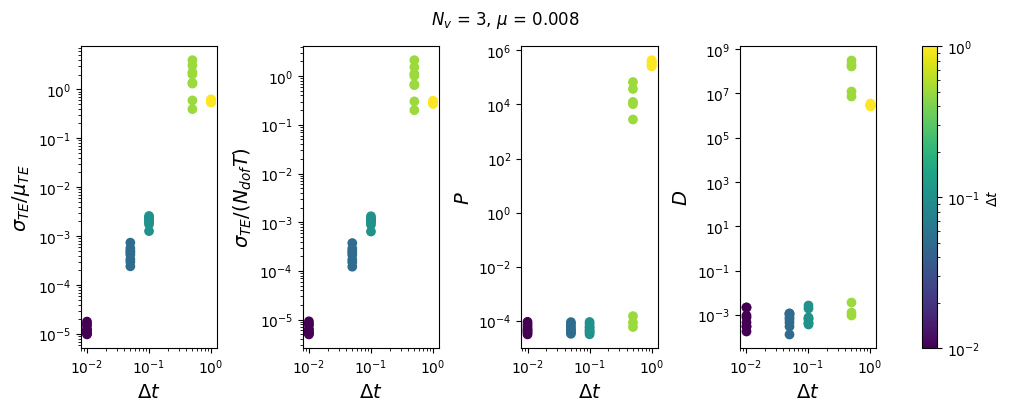

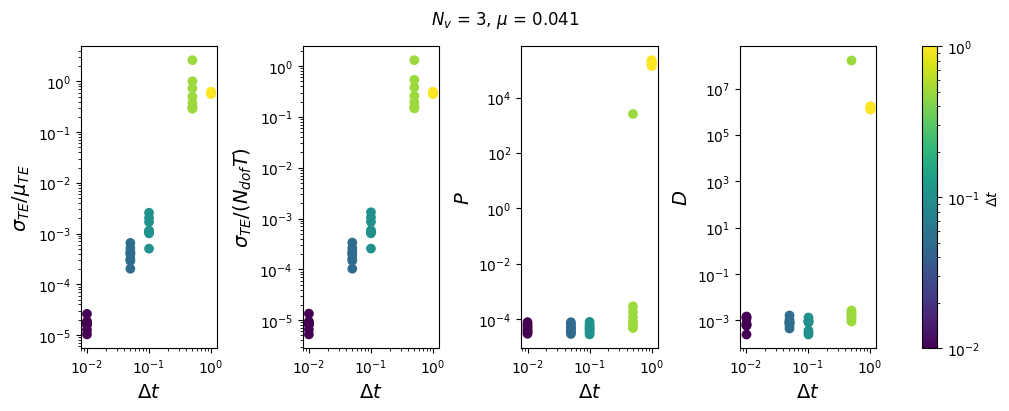

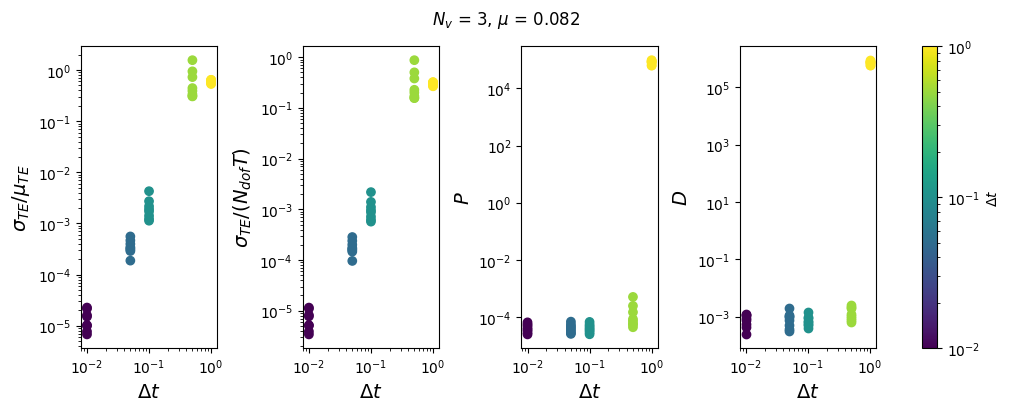

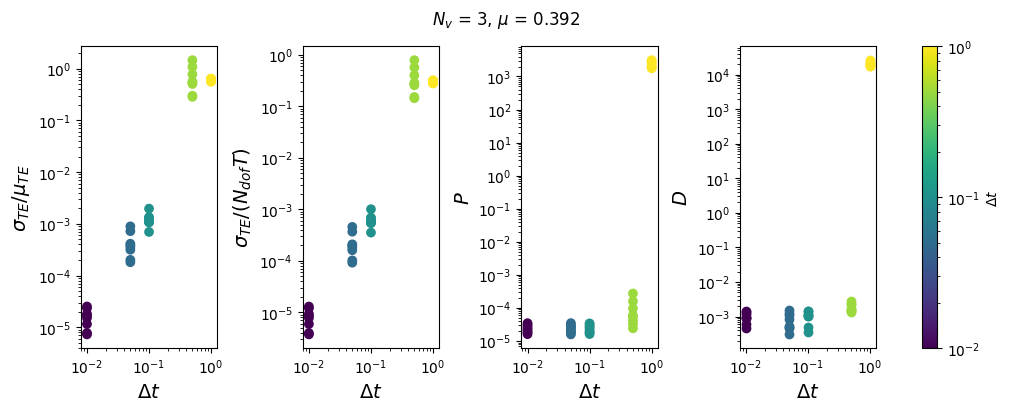

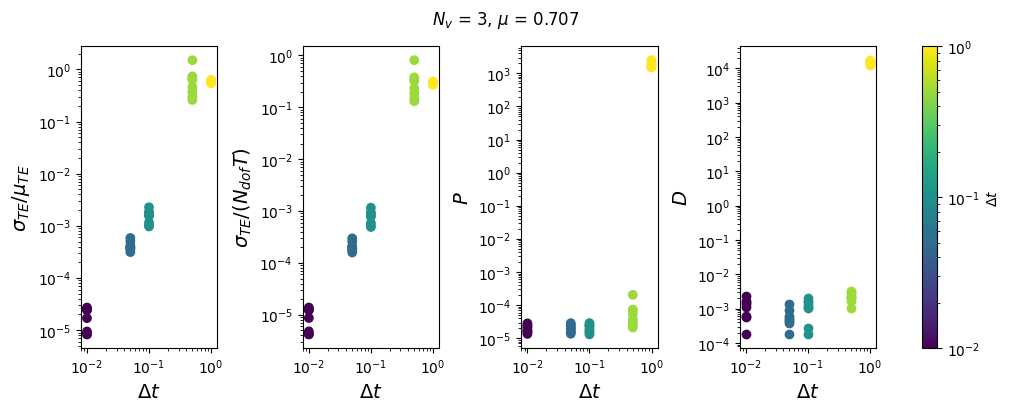

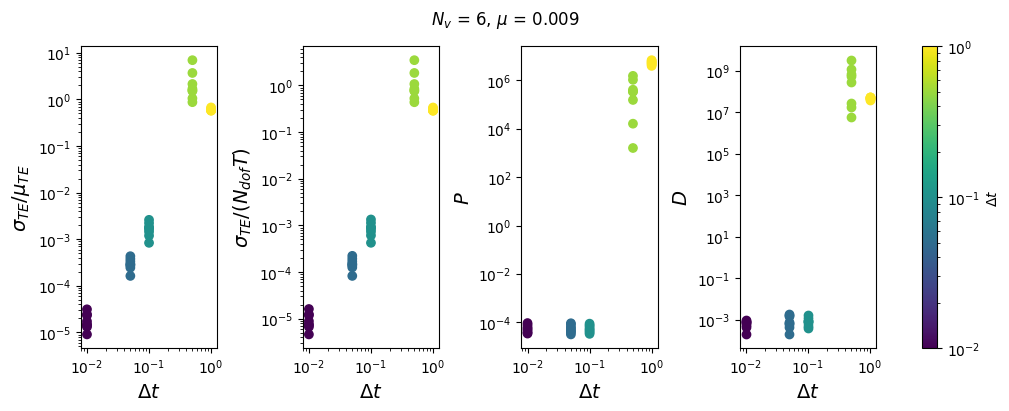

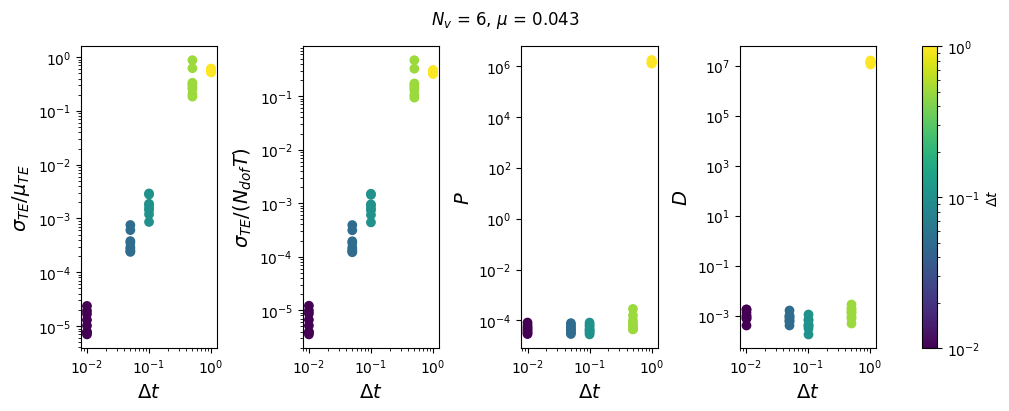

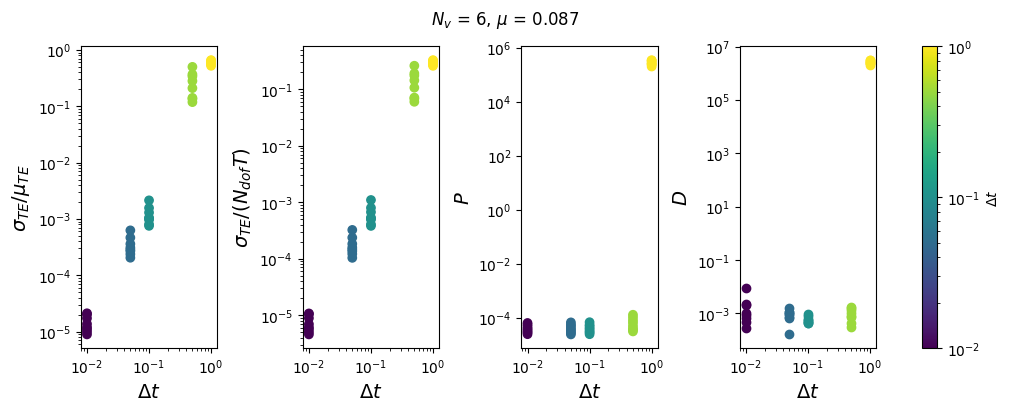

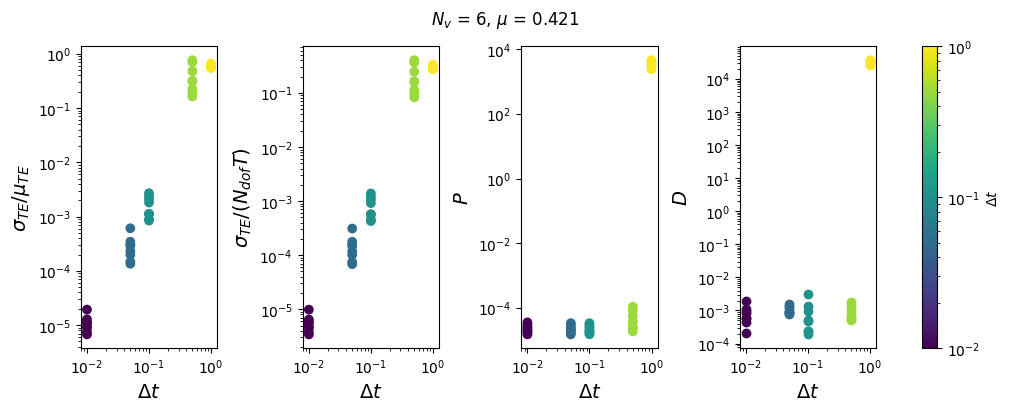

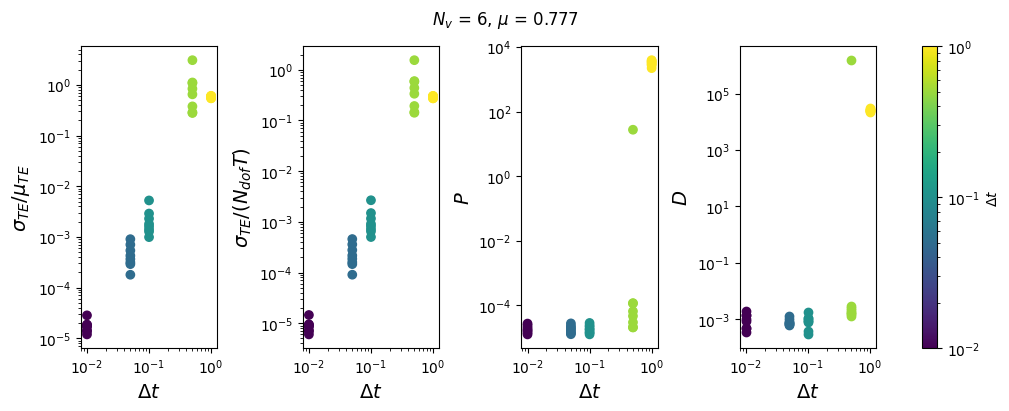

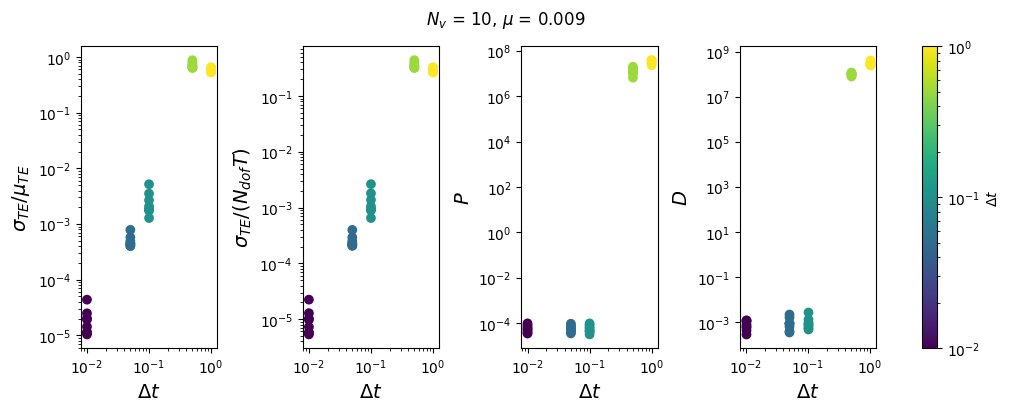

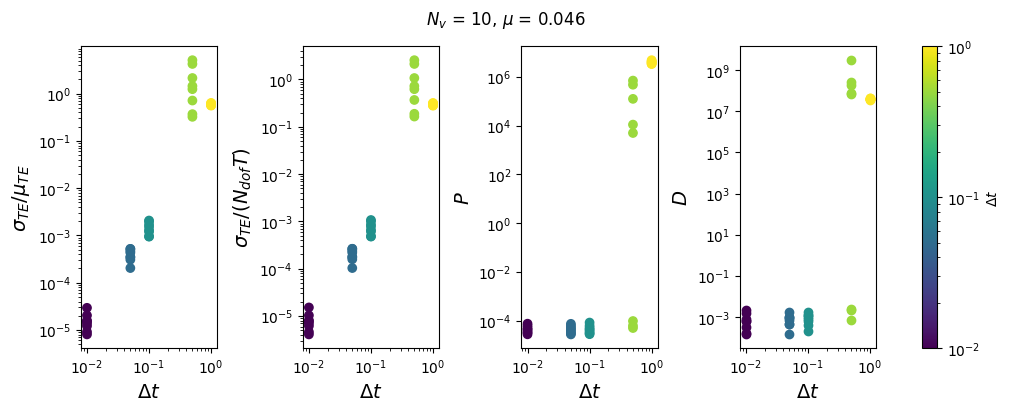

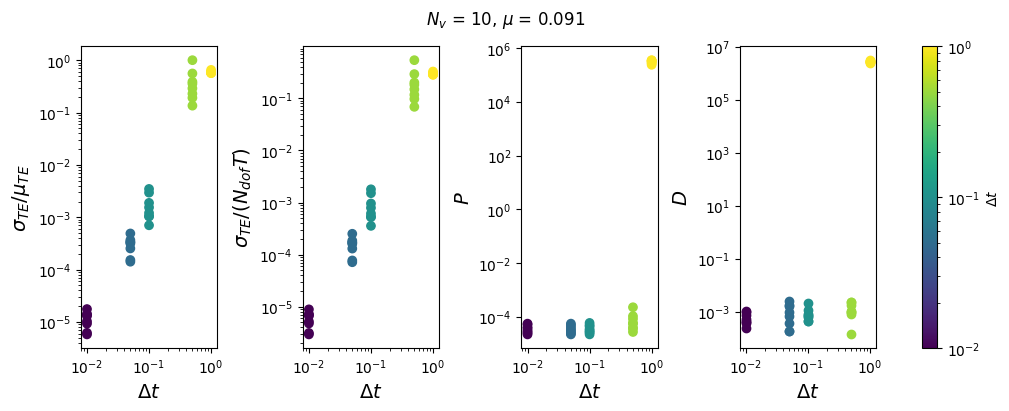

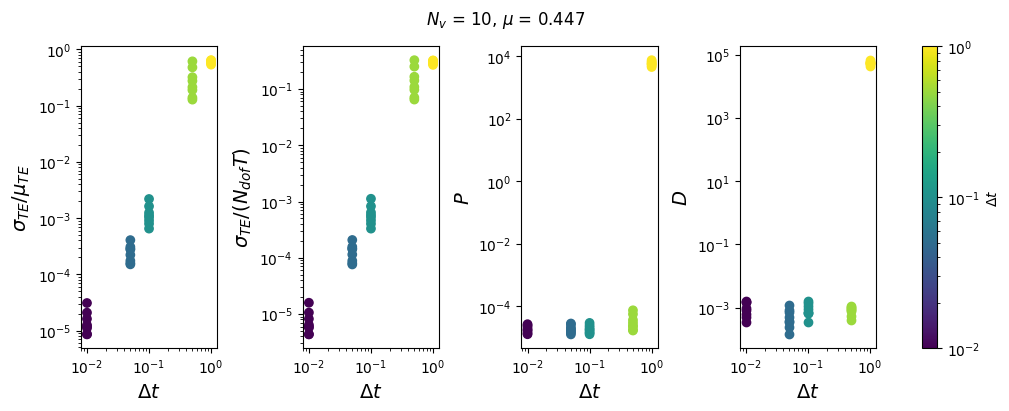

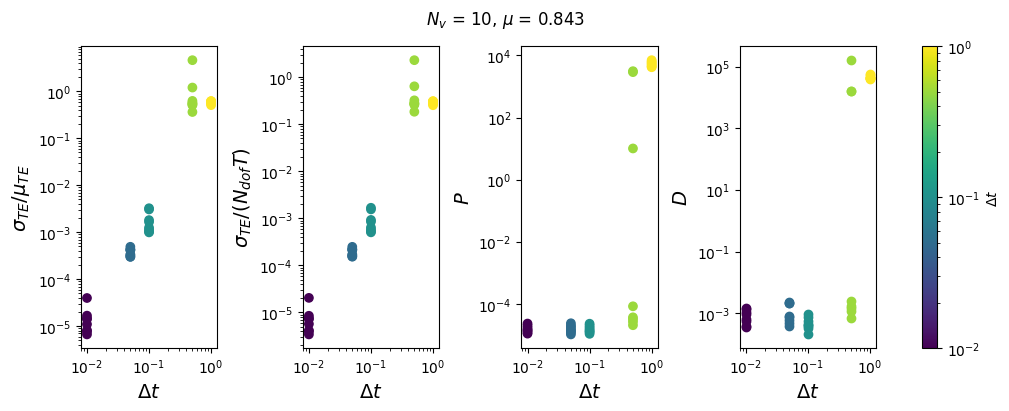

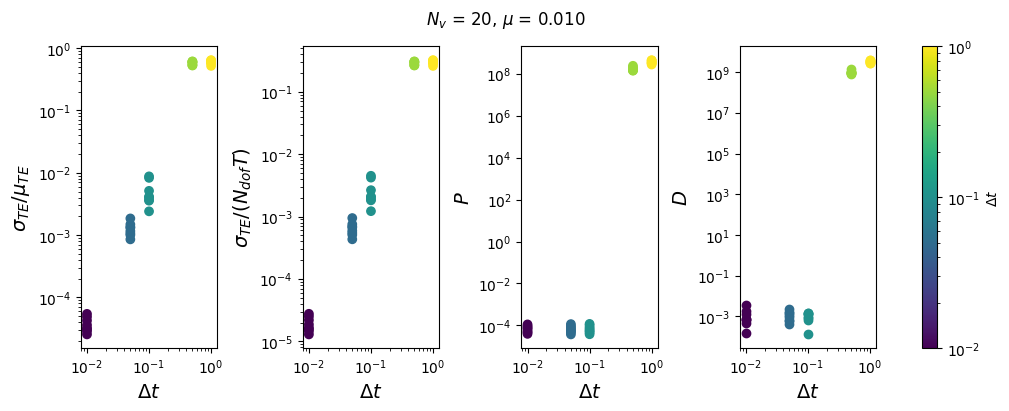

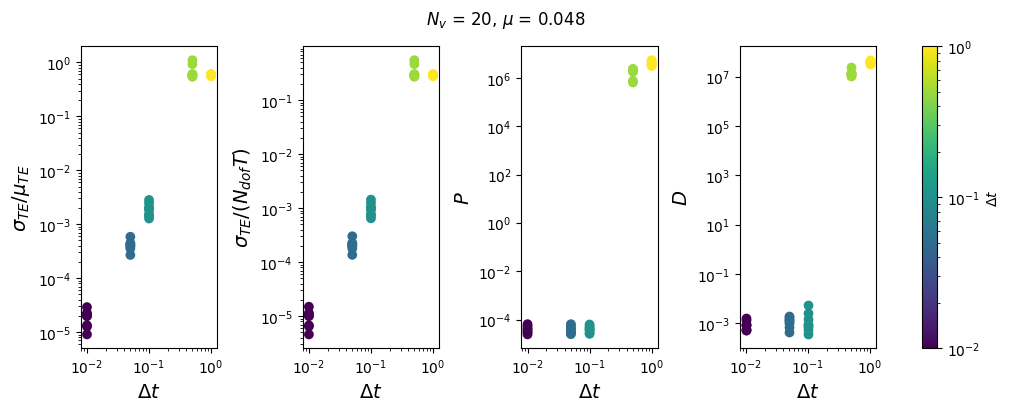

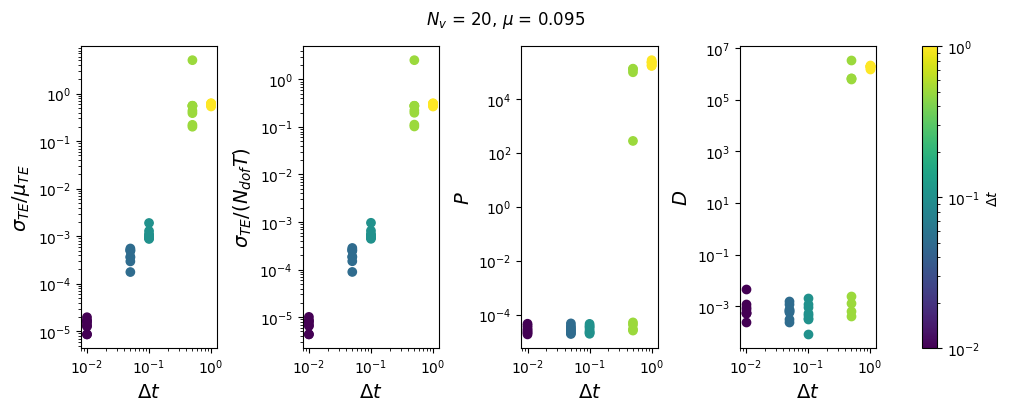

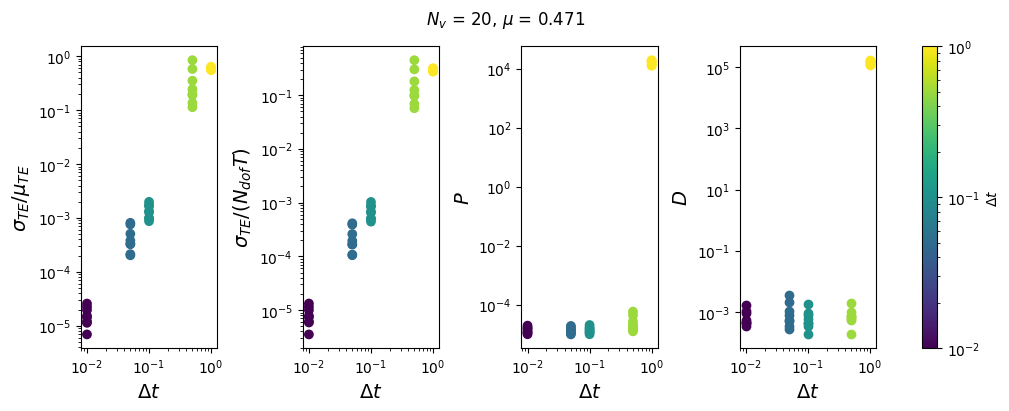

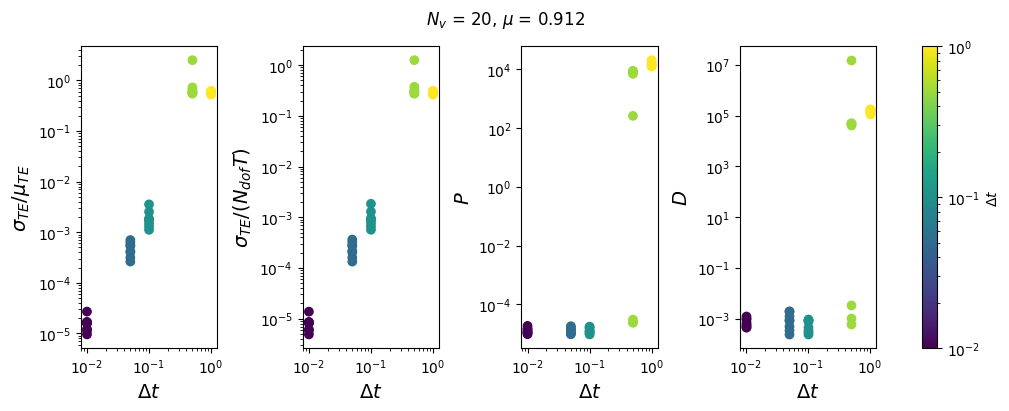

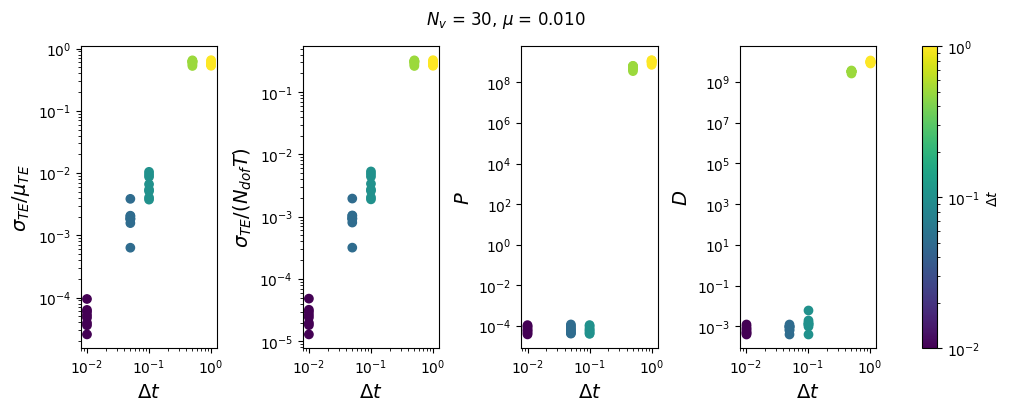

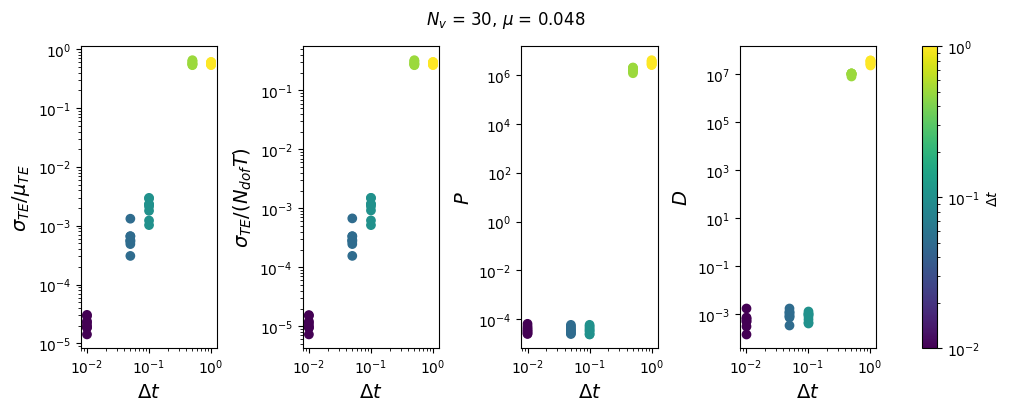

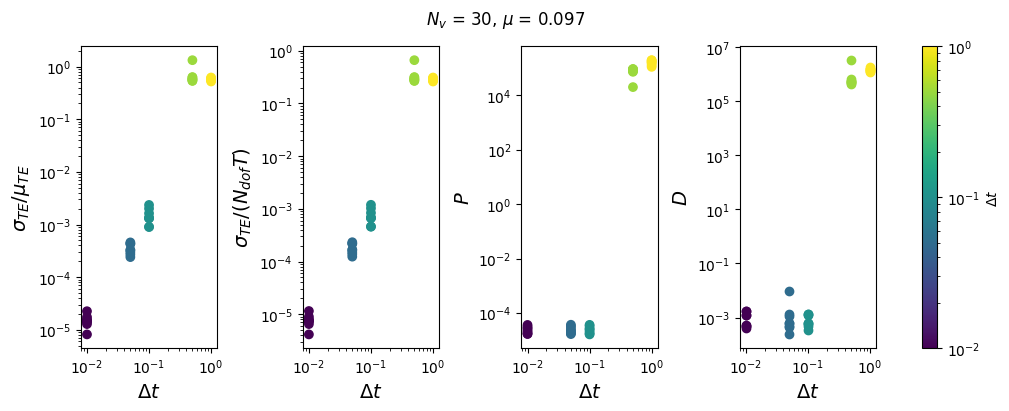

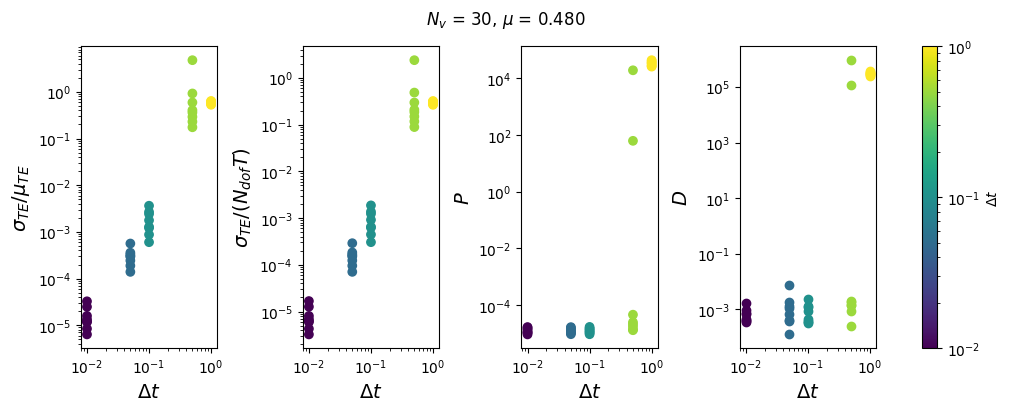

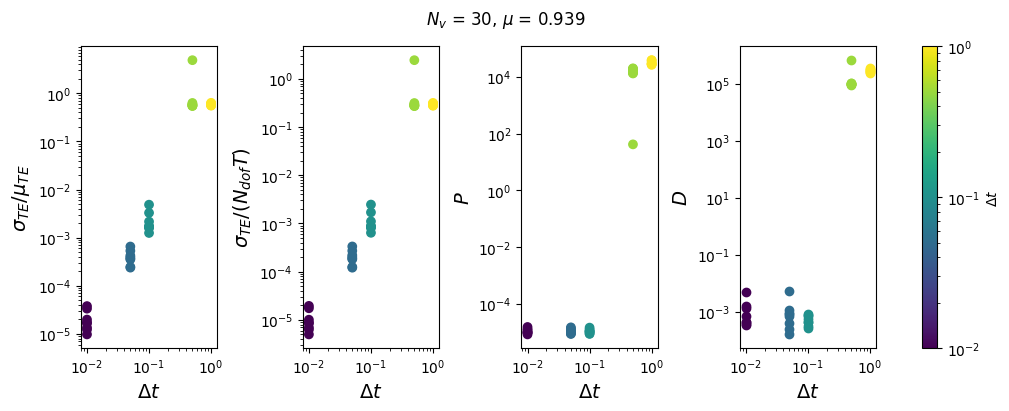

In [70]:
cmap = plt.cm.viridis
dt_norm = LogNorm(vmin=dt_hist.min(), vmax=dt_hist.max())
unique_params = np.unique(np.column_stack((nv_hist.flatten(), mu_hist.flatten())), axis=0)
for nv, mu in unique_params:
    save_root = 'hp-limit-figures/dt-study/'
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    mask = (nv_hist == nv) & (mu_hist == mu)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4), constrained_layout=True)
    ax[0].scatter(dt_hist[mask], te_fluc_hist[mask], c=cmap(dt_norm(dt_hist[mask])))
    ax[1].scatter(dt_hist[mask], rel_te_fluc_hist[mask], c=cmap(dt_norm(dt_hist[mask])))
    ax[2].scatter(dt_hist[mask], p_hist[mask], c=cmap(dt_norm(dt_hist[mask])))
    for dt in np.unique(dt_hist[mask])[::-1]:
        for i, j in np.argwhere(mask & (dt_hist == dt)):
            t = t_hist[i] * dt
            msd = msd_hist[i][:, j]
            fit_mask = t > t.max() / 10
            n, log_D = np.polyfit(np.log10(t[fit_mask]), np.log10(msd[fit_mask]), 1)
            D = 10 ** log_D
            ax[3].scatter(dt, D, c=cmap(dt_norm(dt)))
    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlabel(r'$\Delta t$', fontsize=14)
    ax[0].set_ylabel(r'$\sigma_{TE} / \mu_{TE}$', fontsize=14)
    ax[1].set_ylabel(r'$\sigma_{TE} / (N_{dof} T)$', fontsize=14)
    ax[2].set_ylabel(r'$P$', fontsize=14)
    ax[3].set_ylabel(r'$D$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
    sm = plt.cm.ScalarMappable(norm=dt_norm, cmap=cmap)
    sm.set_array(dt_hist[(nv_hist == nv) & (mu_hist == mu)])
    cbar = plt.colorbar(sm, ax=ax, label=r'$\Delta t$')
    plt.savefig(os.path.join(save_root, f'nv-{int(nv) - 1}-mu-{mu:.3f}.png'), dpi=300)
    plt.show()

# Redoing the above, but using the same initial conditions for all runs and only looking at one $\phi$

array([99900], dtype=int32)

In [39]:
nv_hist = []
mu_hist = []
p_hist = []
temp_hist = []
phi_hist = []
msd_hist = []
t_hist = []
te_fluc_hist = []
rel_te_fluc_hist = []
dt_hist = []
for hp_root in [
    # '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final/',
    # '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-v2/',
    # '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-v3/',
    # '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-v4/',
    # '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-v5/',

    '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-final-v1/',
    '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-final-v2/',
    '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-final-v3/',
    '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-final-v4/',
    '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-final-v5/',
    '/home/mmccraw/dev/data/09-27-25/dt-study-revised-final-final-v6/',

    # '/home/mmccraw/dev/data/09-27-25/dt-study-revised/',
]:
    if not os.path.exists(hp_root):
        continue
    for dt_root in os.listdir(hp_root):
        dt_root = os.path.join(hp_root, dt_root)
        for run_name in os.listdir(dt_root):
            if 'dynamics' not in run_name:
                continue
            run_dir = os.path.join(dt_root, run_name)
            try:
                data = load(run_dir, location=['final', 'init'], load_trajectory=True, load_full=True)
            except:
                continue
            data.calculate_mu_eff()
            nv = data.n_vertices_per_particle[data.system_offset[:-1]]
            mu = data.mu_eff[data.system_offset[:-1]]
            temp = np.mean(data.trajectory.temperature, axis=0)
            phi = data.packing_fraction.copy()
            p = np.mean([data.trajectory[i].pressure for i in range(data.trajectory.num_frames())], axis=0)
            te = np.array([data.trajectory[i].pe_total + data.trajectory[i].ke_total for i in range(data.trajectory.num_frames())])
            te_fluc = np.std(te, axis=0) / np.mean(te, axis=0)
            rel_te_fluc = np.std(te, axis=0) / (data.n_dof() * temp)

            gmsd_path = os.path.join(run_dir, 'gmsd.npz')
            gmsd, t = compute_rotational_msd(data, gmsd_path)
            msd = gmsd[:, :, 0]
            amsd = gmsd[:, :, 1]

            nv_hist.append(nv)
            mu_hist.append(mu)
            p_hist.append(p)
            temp_hist.append(temp)
            phi_hist.append(phi)
            msd_hist.append(msd)
            t_hist.append(t)
            te_fluc_hist.append(te_fluc)
            rel_te_fluc_hist.append(rel_te_fluc)
            dt_hist.append([float(os.path.basename(dt_root).split('_')[1])] * te_fluc.size)

nv_hist = np.array(nv_hist)
mu_hist = np.array(mu_hist)
p_hist = np.array(p_hist)
temp_hist = np.array(temp_hist)
phi_hist = np.array(phi_hist)
te_fluc_hist = np.array(te_fluc_hist)
rel_te_fluc_hist = np.array(rel_te_fluc_hist)
dt_hist = np.array(dt_hist)

Loading trajectory:   0%|          | 0/7 [00:00<?, ?it/s]

Binned accumulation: 100%|██████████| 22005/22005 [00:02<00:00, 10339.82it/s]


900000
100000
90000


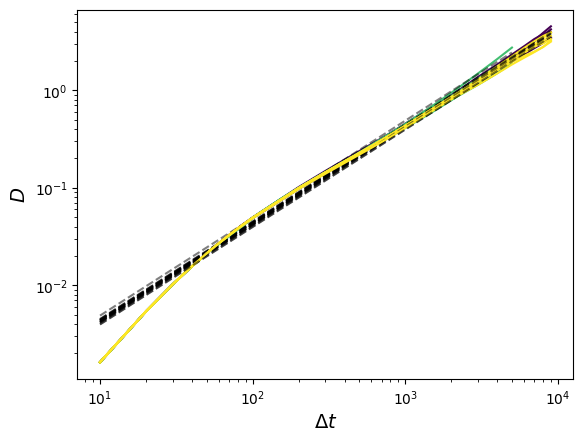

In [40]:
from scipy.optimize import minimize
def obj_func(b, x, y):
    return np.sum((x + b - y) ** 2)

error_tolerance = 1e-2  # 1% error in diffusion coef and pressure
cmap = plt.cm.viridis
dt_norm = LogNorm(vmin=dt_hist.min(), vmax=dt_hist.max())
unique_params = np.unique(np.column_stack((nv_hist.flatten(), mu_hist.flatten())), axis=0)
for nv, mu in unique_params:
    save_root = 'hp-limit-figures/dt-study-revised/'
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    mask = (nv_hist == nv) & (mu_hist == mu)
    # fig, ax = plt.subplots(1, 4, figsize=(10, 4), constrained_layout=True)
    # ax[0].scatter(dt_hist[mask], te_fluc_hist[mask], c=cmap(dt_norm(dt_hist[mask])))
    # ax[1].scatter(dt_hist[mask], rel_te_fluc_hist[mask], c=cmap(dt_norm(dt_hist[mask])))
    # ax[2].scatter(dt_hist[mask], p_hist[mask], c=cmap(dt_norm(dt_hist[mask])))
    x = np.unique(dt_hist[mask].copy())
    y1 = x ** 2 * te_fluc_hist[mask][np.argmin(dt_hist[mask])] / (np.min(dt_hist[mask]) ** 2)
    y2 = x ** 2 * rel_te_fluc_hist[mask][np.argmin(dt_hist[mask])] / (np.min(dt_hist[mask]) ** 2)
    # ax[0].plot(x, y1, c='k', zorder=0, ls='--', alpha=0.5)
    # ax[1].plot(x, y2, c='k', zorder=0, ls='--', alpha=0.5)
    # ax[2].axhline(p_hist[mask][np.argmin(dt_hist[mask])] * (1 + error_tolerance), c='k', zorder=0, ls='--', alpha=0.5)
    # ax[2].axhline(p_hist[mask][np.argmin(dt_hist[mask])] * (1 - error_tolerance), c='k', zorder=0, ls='--', alpha=0.5)
    d_range = []
    p_range = np.unique(p_hist[mask])
    for dt in np.sort(np.unique(dt_hist[mask])):
        for i, j in np.argwhere(mask & (dt_hist == dt)):
            t = t_hist[i] * dt
            msd = msd_hist[i][:, j]
            fit_mask = t > t.max() / 20
            # n, log_D = np.polyfit(np.log10(t[fit_mask]), np.log10(msd[fit_mask]), 1)
            # D = 10 ** log_D
            # fit D to the last 20% of the data assuming the form is msd = D * t^1:
            D = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[fit_mask]), np.log10(msd[fit_mask]))).x[0]
            d_range.append(D)
            plt.plot(t, msd, c=cmap(dt_norm(dt)))
            plt.plot(t, t * D, c='k', ls='--', alpha=0.5)
        print(t_hist[i].max())
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\Delta t$', fontsize=14)
    plt.ylabel(r'$D$', fontsize=14)
    plt.show()
            # ax[3].scatter(dt, D, c=cmap(dt_norm(dt)))
    # for a in ax:
    #     a.set_xscale('log')
    #     a.set_yscale('log')
    #     a.set_xlabel(r'$\Delta t$', fontsize=14)
    # ax[3].axhline(d_range[0] * (1 + error_tolerance), c='k', zorder=0, ls='--', alpha=0.5)
    # ax[3].axhline(d_range[0] * (1 - error_tolerance), c='k', zorder=0, ls='--', alpha=0.5)
    # ax[0].set_ylabel(r'$\sigma_{TE} / \mu_{TE}$', fontsize=14)
    # ax[1].set_ylabel(r'$\sigma_{TE} / (N_{dof} T)$', fontsize=14)
    # ax[2].set_ylabel(r'$P$', fontsize=14)
    # ax[3].set_ylabel(r'$D$', fontsize=14)
    # plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
    # sm = plt.cm.ScalarMappable(norm=dt_norm, cmap=cmap)
    # sm.set_array(dt_hist[(nv_hist == nv) & (mu_hist == mu)])
    # cbar = plt.colorbar(sm, ax=ax, label=r'$\Delta t$')
    # plt.savefig(os.path.join(save_root, f'nv-{int(nv) - 1}-mu-{mu:.3f}.png'), dpi=300)
    plt.show()
    break

/tmp/ipykernel_1912998/1962750429.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[3].scatter(dt, D, c=cmap(dt_norm(dt)))


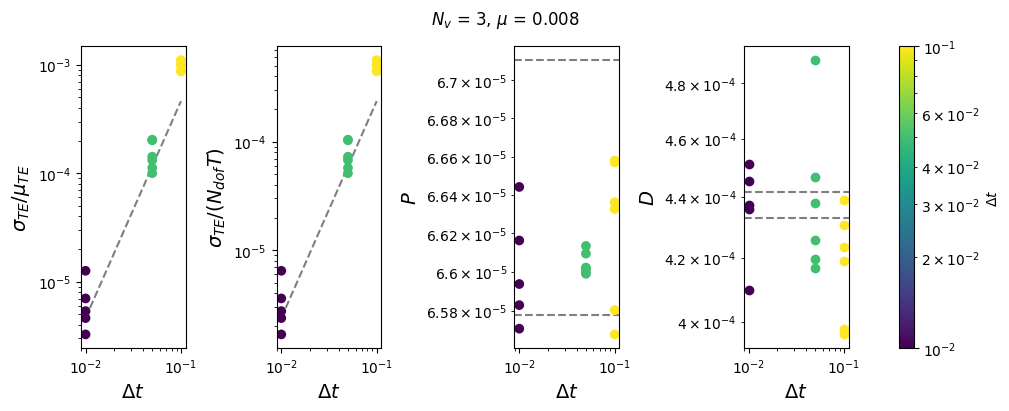

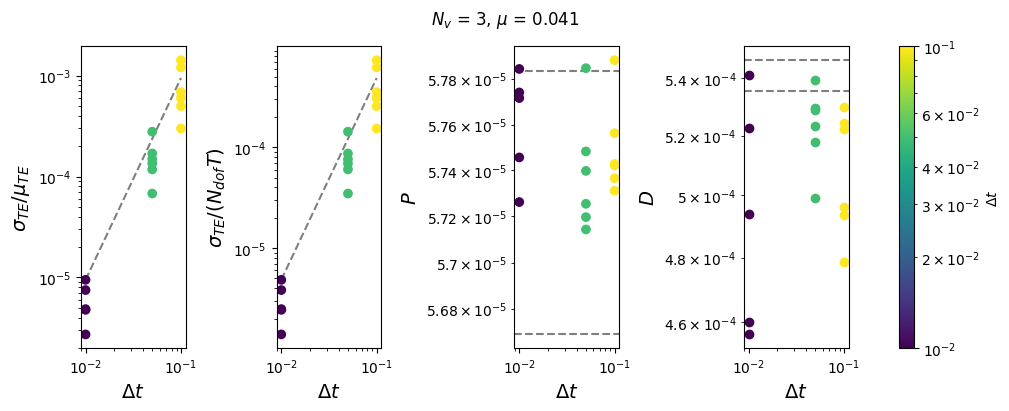

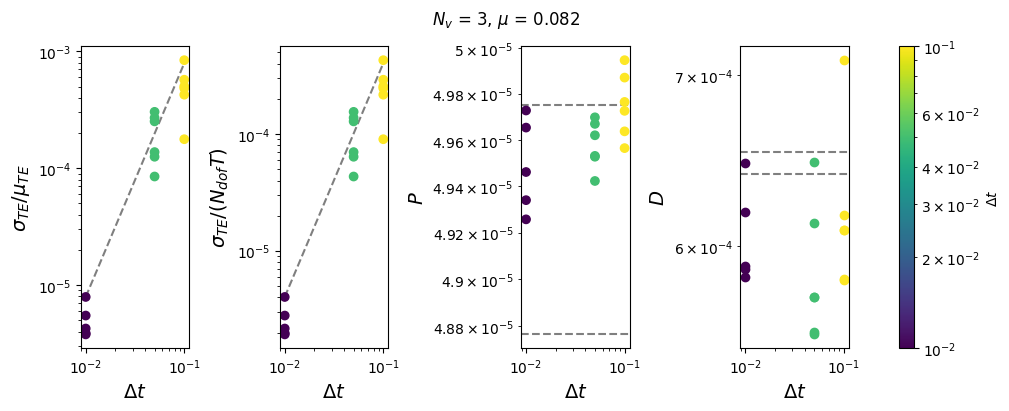

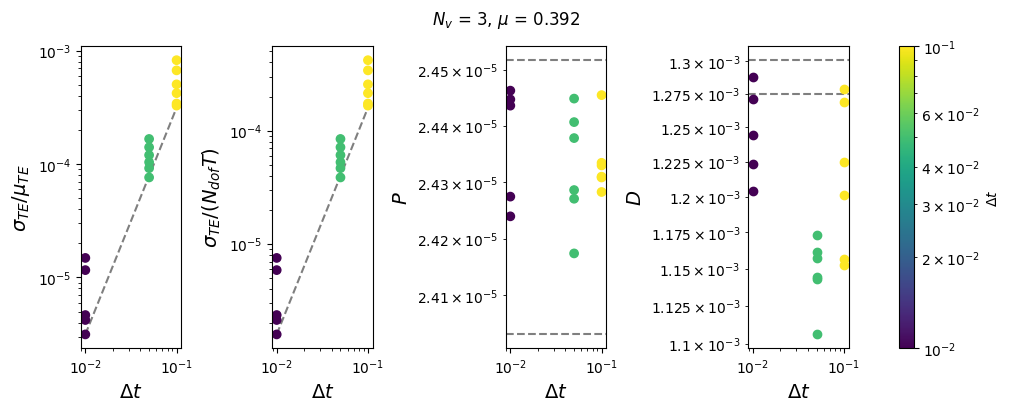

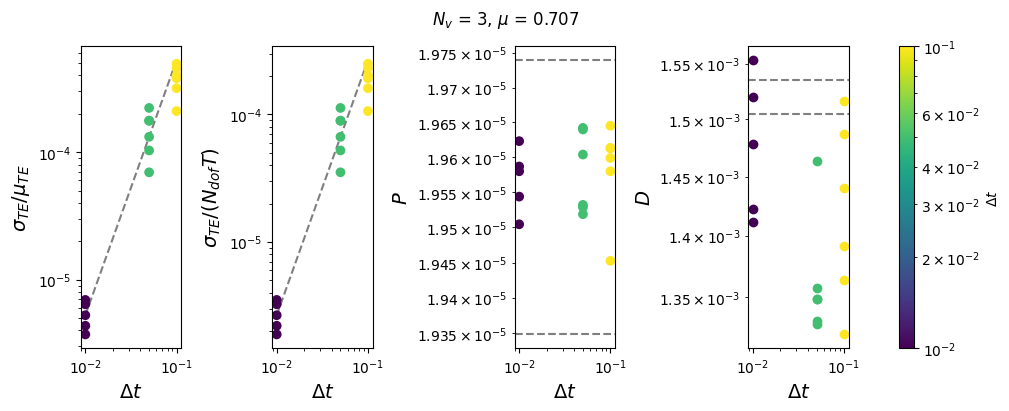

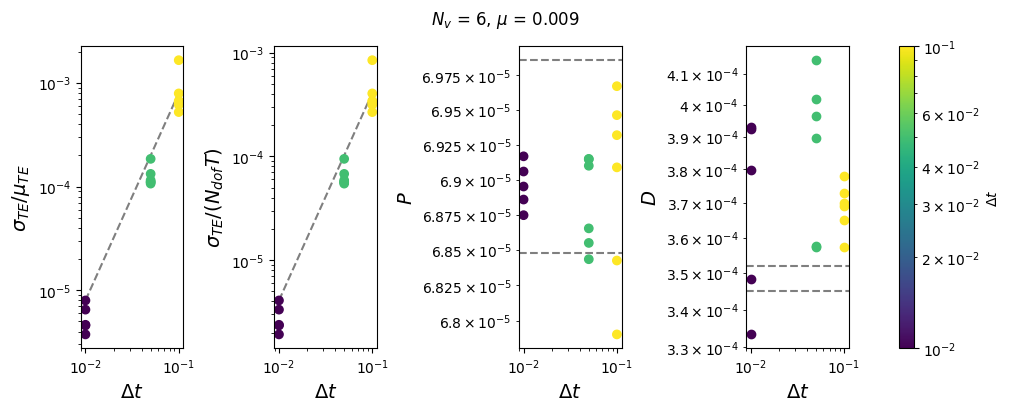

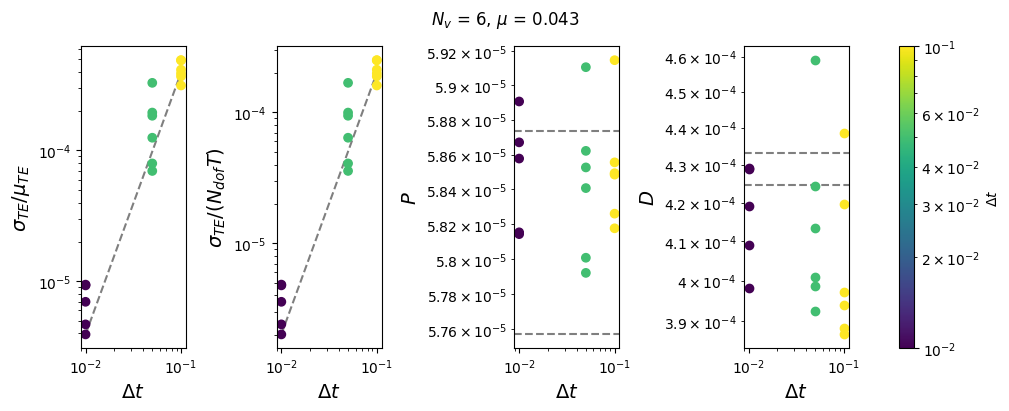

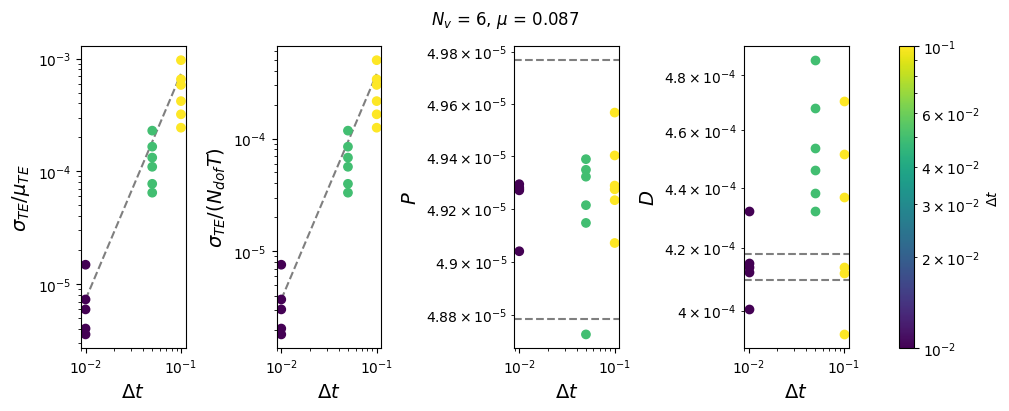

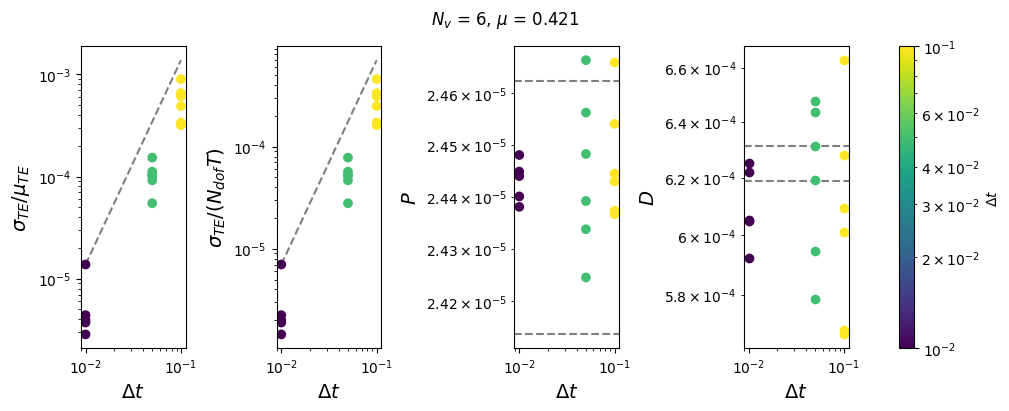

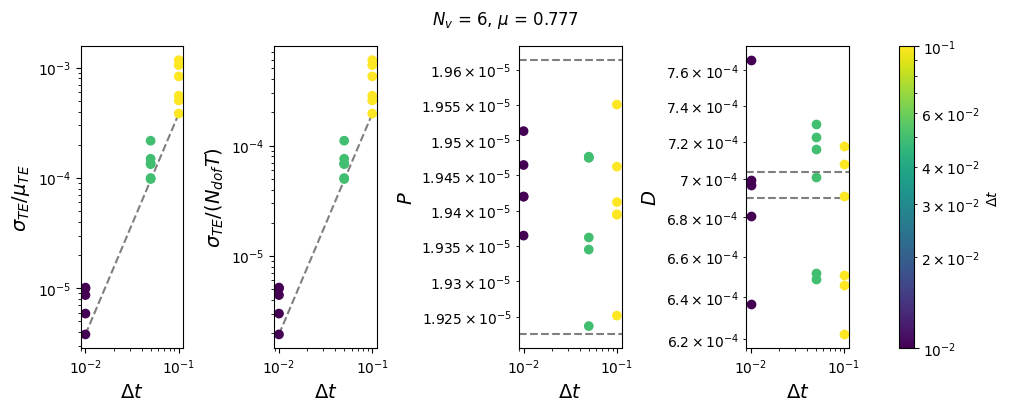

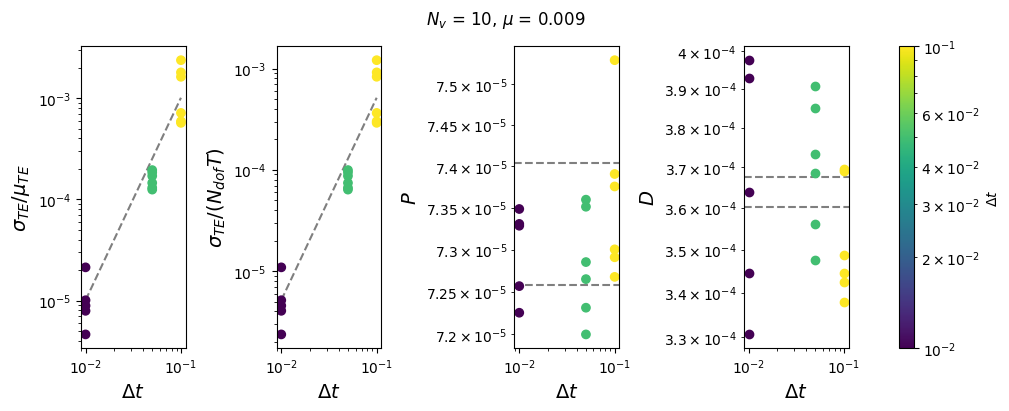

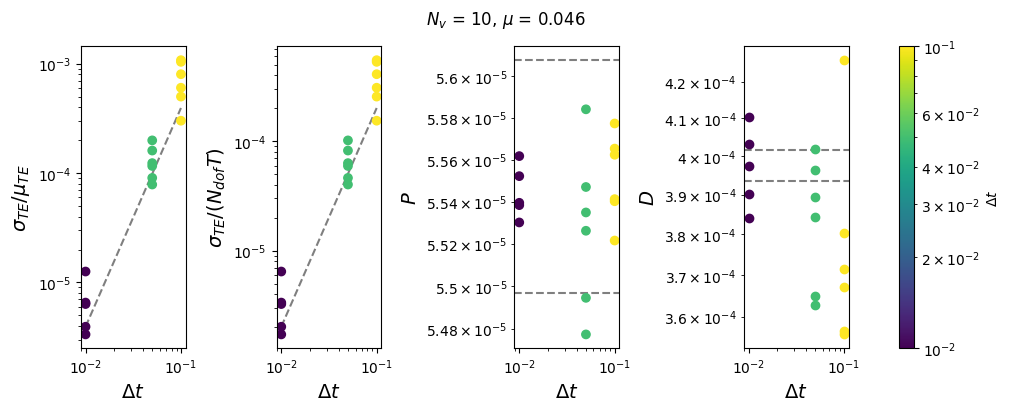

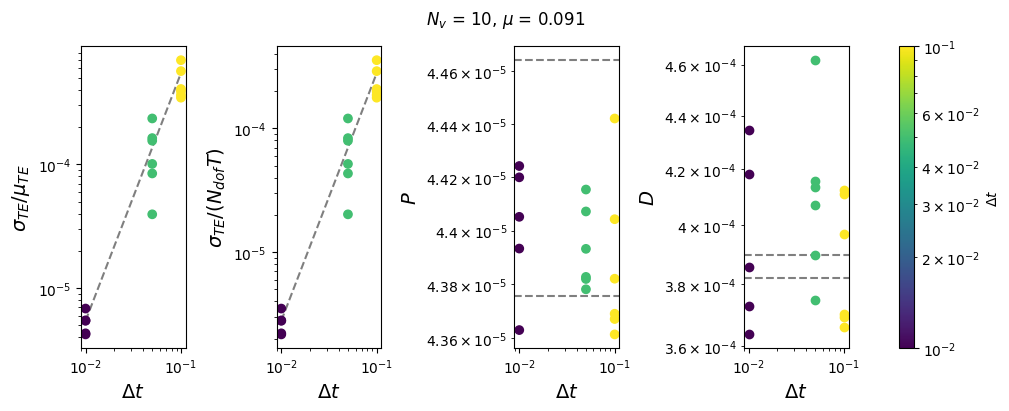

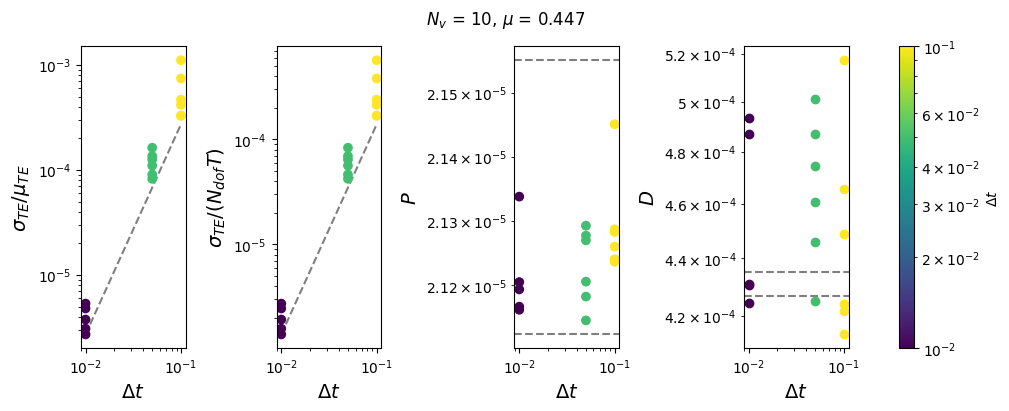

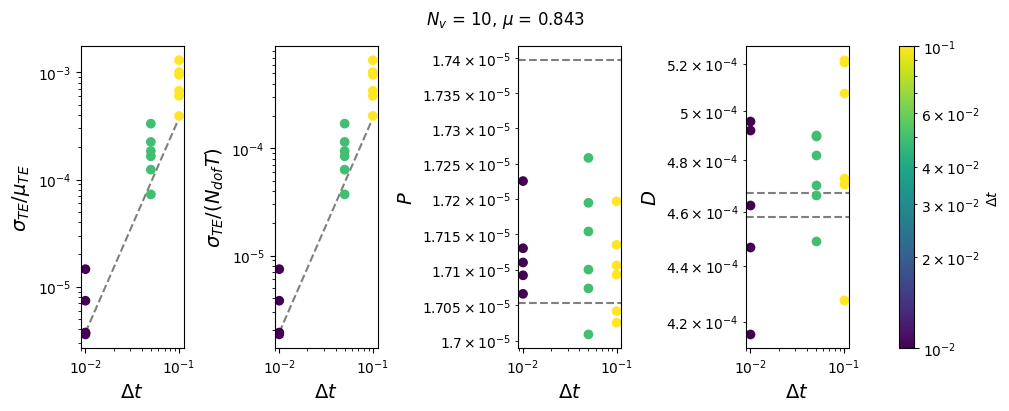

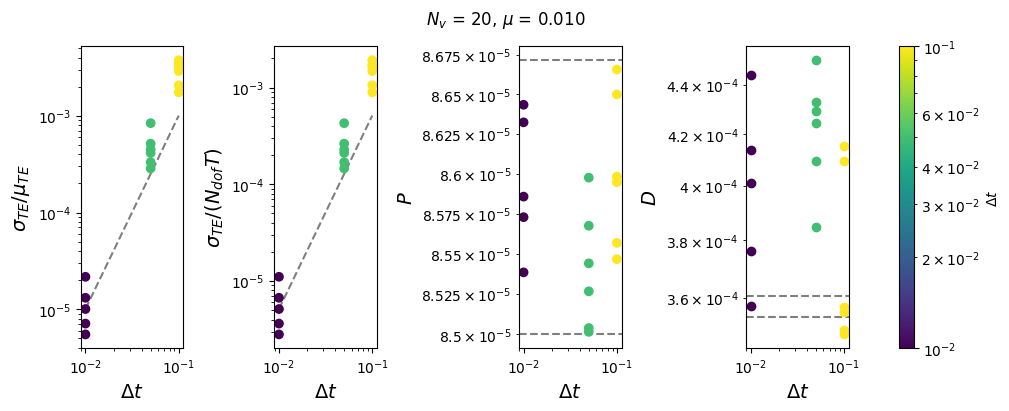

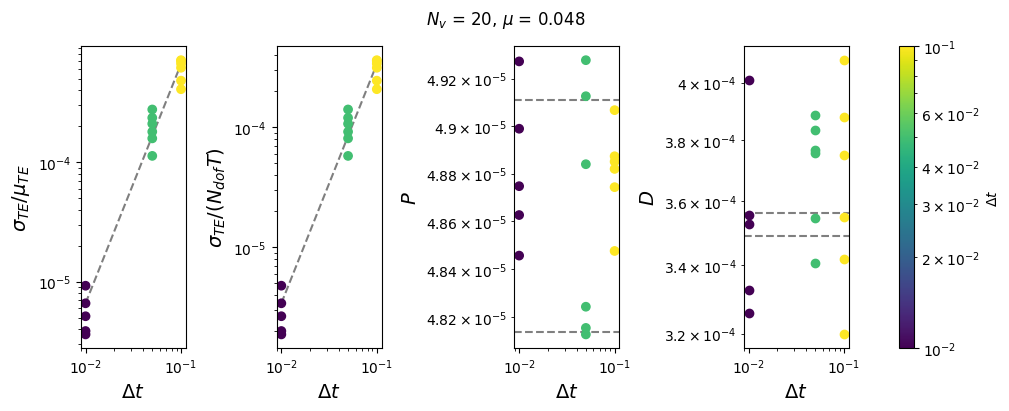

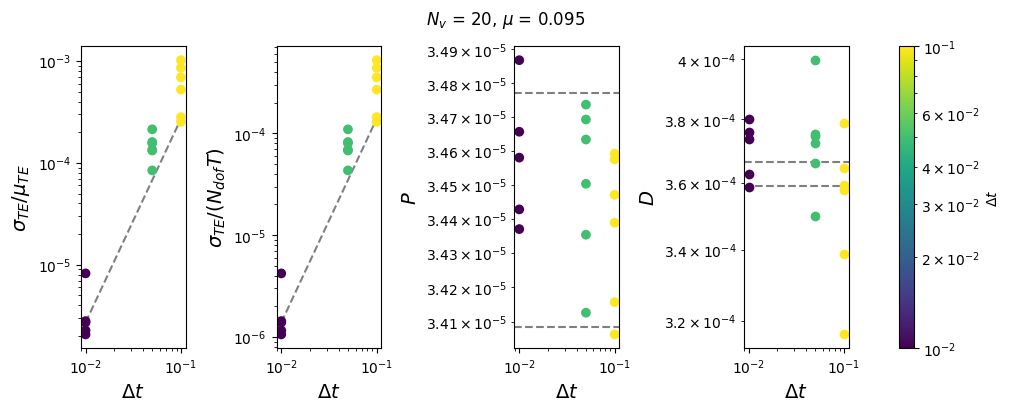

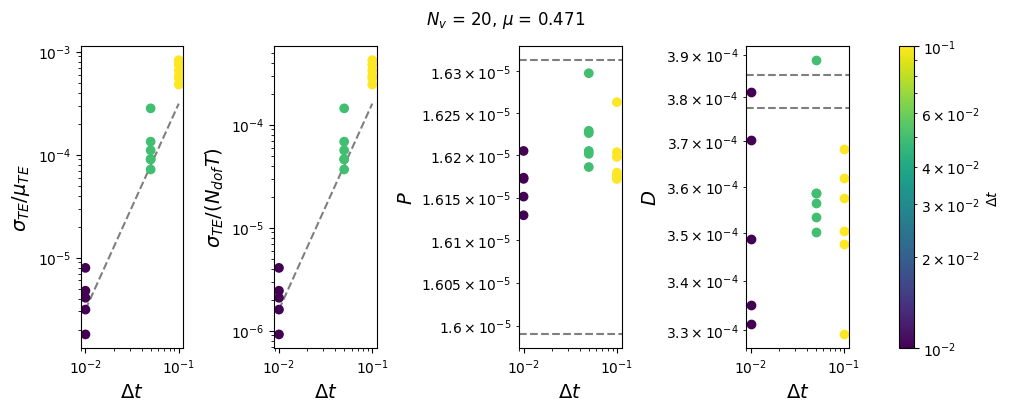

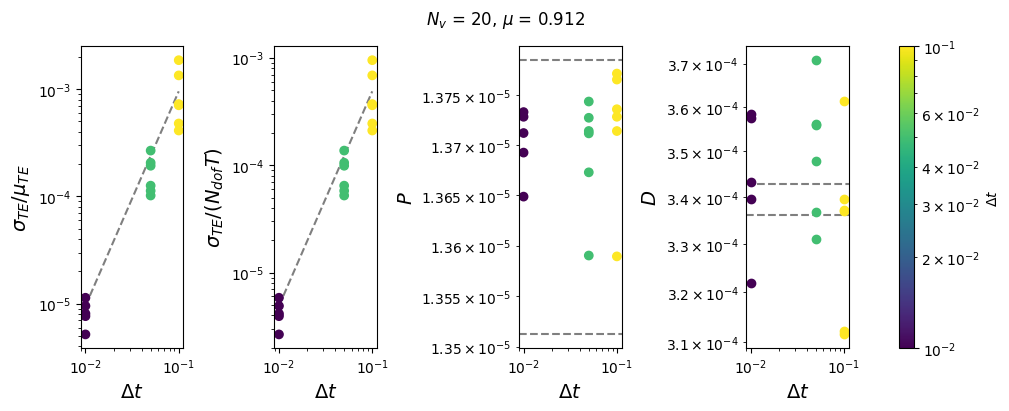

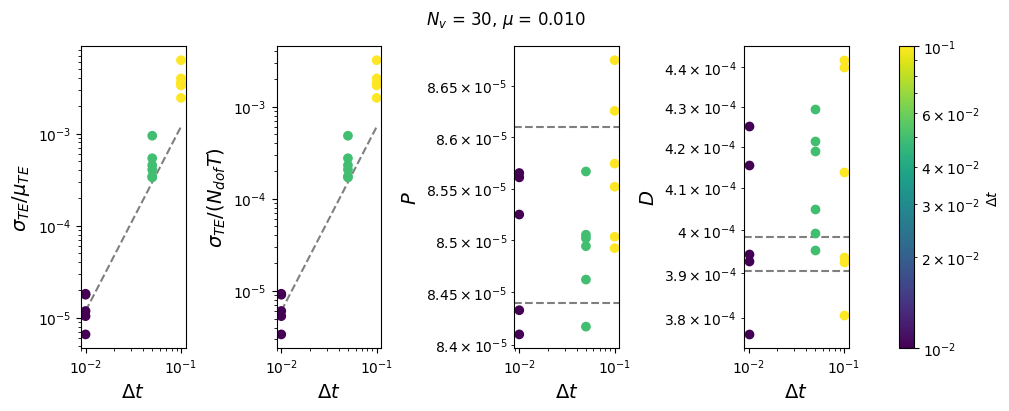

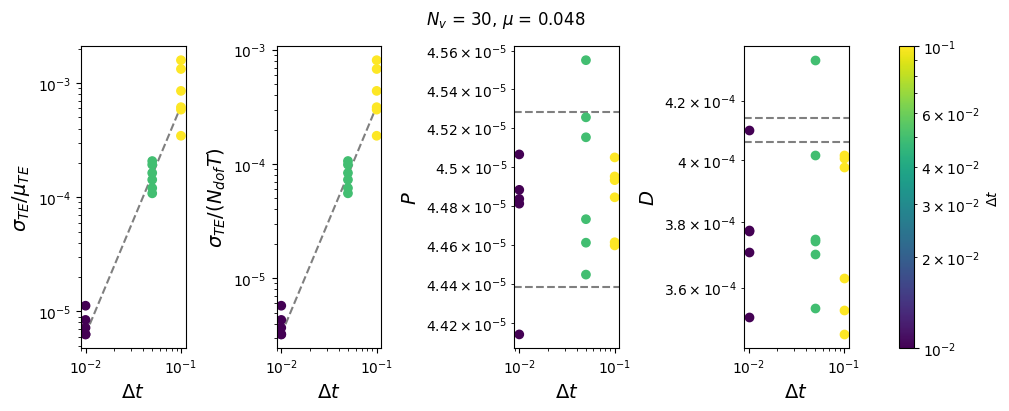

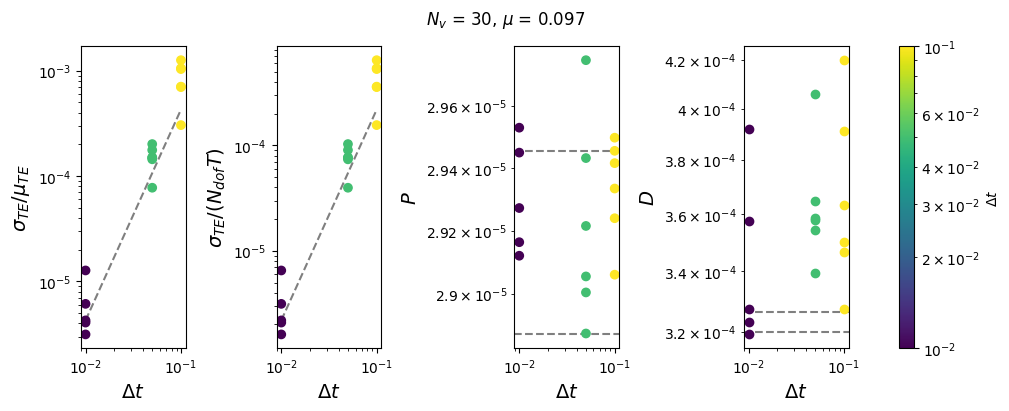

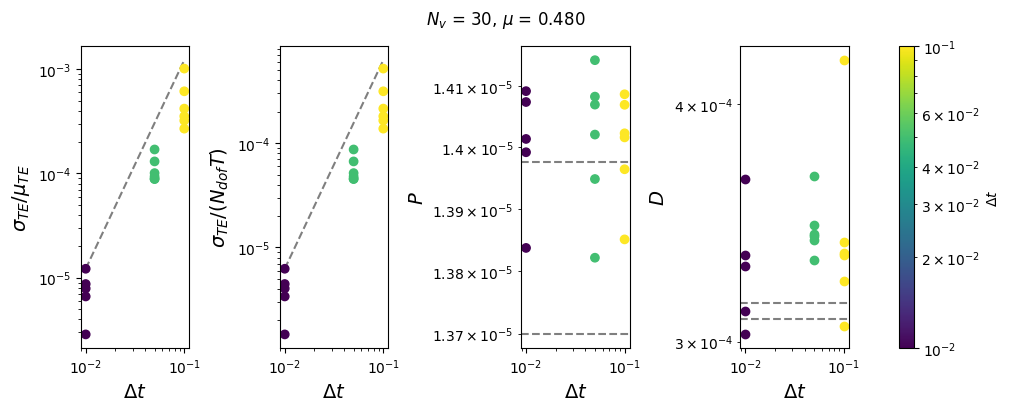

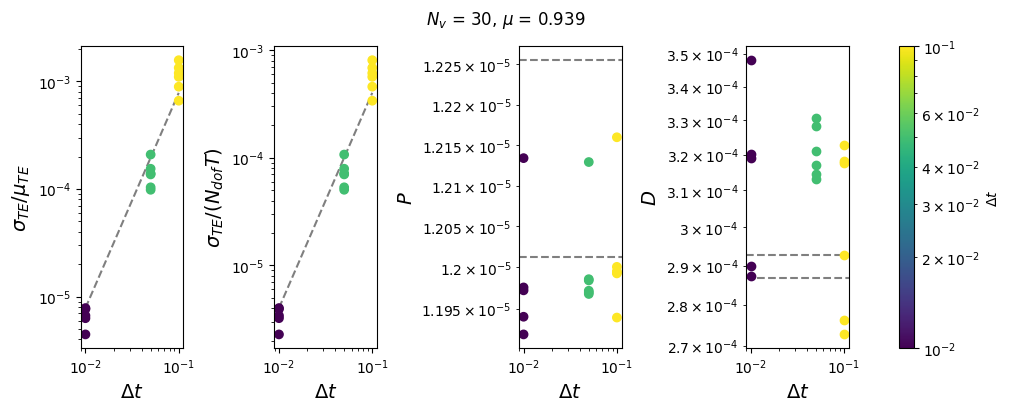

In [41]:
error_tolerance = 1e-2  # 1% error in diffusion coef and pressure
cmap = plt.cm.viridis
dt_norm = LogNorm(vmin=dt_hist.min(), vmax=dt_hist.max())
unique_params = np.unique(np.column_stack((nv_hist.flatten(), mu_hist.flatten())), axis=0)
for nv, mu in unique_params:
    save_root = 'hp-limit-figures/dt-study-revised/'
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    mask = (nv_hist == nv) & (mu_hist == mu)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4), constrained_layout=True)
    ax[0].scatter(dt_hist[mask], te_fluc_hist[mask], c=cmap(dt_norm(dt_hist[mask])))
    ax[1].scatter(dt_hist[mask], rel_te_fluc_hist[mask], c=cmap(dt_norm(dt_hist[mask])))
    ax[2].scatter(dt_hist[mask], p_hist[mask], c=cmap(dt_norm(dt_hist[mask])))
    x = np.unique(dt_hist[mask].copy())
    y1 = x ** 2 * te_fluc_hist[mask][np.argmin(dt_hist[mask])] / (np.min(dt_hist[mask]) ** 2)
    y2 = x ** 2 * rel_te_fluc_hist[mask][np.argmin(dt_hist[mask])] / (np.min(dt_hist[mask]) ** 2)
    ax[0].plot(x, y1, c='k', zorder=0, ls='--', alpha=0.5)
    ax[1].plot(x, y2, c='k', zorder=0, ls='--', alpha=0.5)
    ax[2].axhline(p_hist[mask][np.argmin(dt_hist[mask])] * (1 + error_tolerance), c='k', zorder=0, ls='--', alpha=0.5)
    ax[2].axhline(p_hist[mask][np.argmin(dt_hist[mask])] * (1 - error_tolerance), c='k', zorder=0, ls='--', alpha=0.5)
    d_range = []
    p_range = np.unique(p_hist[mask])
    for dt in np.sort(np.unique(dt_hist[mask])):
        for i, j in np.argwhere(mask & (dt_hist == dt)):
            t = t_hist[i] * dt
            msd = msd_hist[i][:, j]
            fit_mask = t > t.max() / 20
            # fit D to the last 20% of the data assuming the form is msd = D * t^1:
            D = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[fit_mask]), np.log10(msd[fit_mask]))).x[0]
            d_range.append(D)
            ax[3].scatter(dt, D, c=cmap(dt_norm(dt)))
    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlabel(r'$\Delta t$', fontsize=14)
    ax[3].axhline(d_range[0] * (1 + error_tolerance), c='k', zorder=0, ls='--', alpha=0.5)
    ax[3].axhline(d_range[0] * (1 - error_tolerance), c='k', zorder=0, ls='--', alpha=0.5)
    ax[0].set_ylabel(r'$\sigma_{TE} / \mu_{TE}$', fontsize=14)
    ax[1].set_ylabel(r'$\sigma_{TE} / (N_{dof} T)$', fontsize=14)
    ax[2].set_ylabel(r'$P$', fontsize=14)
    ax[3].set_ylabel(r'$D$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
    sm = plt.cm.ScalarMappable(norm=dt_norm, cmap=cmap)
    sm.set_array(dt_hist[(nv_hist == nv) & (mu_hist == mu)])
    cbar = plt.colorbar(sm, ax=ax, label=r'$\Delta t$')
    plt.savefig(os.path.join(save_root, f'nv-{int(nv) - 1}-mu-{mu:.3f}.png'), dpi=300)
    plt.show()